## Step 0: Configure PySpark environment

In [137]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
12,application_1716655330247_0016,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
11,application_1716655330247_0015,pyspark,error,Link,Link,
12,application_1716655330247_0016,pyspark,idle,Link,Link,✔


In [138]:
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f9/77/e3046bf19720b22e3e0b7c12e28f6f2c0c18a213fb91a56cea640862270f/kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x

In [139]:
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.feature import Bucketizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Normalizer
import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Step 1: Data Processing and Visualization

In [140]:
## radius_ 1km
data_y0_1km = spark.read.csv('s3://africamining/complete_data_y0.csv', header=True, inferSchema=True)
data_y1_1km = spark.read.csv('s3://africamining/complete_data_y1.csv', header=True, inferSchema=True)

## radius_5km
data_y0_5km = spark.read.csv('s3://africamining/complete_data_y0_200k.csv', header=True, inferSchema=True)
data_y1_5km = spark.read.csv('s3://africamining/complete_data_y1_radius5k.csv', header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [141]:
from pyspark.sql.functions import rand
# Combine the datasets with radius 
combined_data_1km = data_y0_1km.union(data_y1_1km)
# Randomly order the combined dataset
data_1km = combined_data_1km.orderBy(rand())


combined_data_5km = data_y0_5km.union(data_y1_5km)
data_5km = combined_data_5km.orderBy(rand())



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
print('Total Columns: %d' % len(data_1km.dtypes))
print('Total Rows: %d' % data_1km.count())
data_1km.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 16
Total Rows: 39351
root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- NDVI_Loss: double (nullable = true)
 |-- Band1_2023: double (nullable = true)
 |-- Band2_2023: double (nullable = true)
 |-- Band3_2023: double (nullable = true)
 |-- Band6_2023: double (nullable = true)
 |-- Band10_2023: double (nullable = true)
 |-- geometry: string (nullable = true)
 |-- potential_mining: integer (nullable = true)
 |-- distance_to_village: double (nullable = true)
 |-- distance_to_waterway: double (nullable = true)
 |-- distance_to_local_road: double (nullable = true)
 |-- distance_to_main_road: double (nullable = true)
 |-- distance_to_protected_area: double (nullable = true)

In [40]:
print('Total Columns: %d' % len(data_5km.dtypes))
print('Total Rows: %d' % data_5km.count())
data_5km.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 16
Total Rows: 390220
root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- NDVI_Loss: double (nullable = true)
 |-- Band1_2023: double (nullable = true)
 |-- Band2_2023: double (nullable = true)
 |-- Band3_2023: double (nullable = true)
 |-- Band6_2023: double (nullable = true)
 |-- Band10_2023: double (nullable = true)
 |-- geometry: string (nullable = true)
 |-- potential_mining: integer (nullable = true)
 |-- distance_to_village: double (nullable = true)
 |-- distance_to_waterway: double (nullable = true)
 |-- distance_to_local_road: double (nullable = true)
 |-- distance_to_main_road: double (nullable = true)
 |-- distance_to_protected_area: double (nullable = true)

In [43]:
data_1km.describe(['NDVI_Loss']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|summary|           NDVI_Loss|
+-------+--------------------+
|  count|               39351|
|   mean| 0.18206206861197935|
| stddev|0.034937782799368725|
|    min|          0.15000047|
|    max|          0.44723216|
+-------+--------------------+

In [45]:
data_5km.describe(['NDVI_Loss']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
|summary|          NDVI_Loss|
+-------+-------------------+
|  count|             390220|
|   mean| 0.1846464556640101|
| stddev|0.03680224110693226|
|    min|         0.15000007|
|    max|         0.46836734|
+-------+-------------------+

In [10]:
data_1km.describe(['Band10_2023']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|       Band10_2023|
+-------+------------------+
|  count|             39351|
|   mean| 43059.94204263401|
| stddev|10937.688646902776|
|    min|               0.0|
|    max|           65535.0|
+-------+------------------+

In [46]:
data_5km.describe(['Band10_2023']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
|summary|      Band10_2023|
+-------+-----------------+
|  count|           390220|
|   mean|43618.48531268784|
| stddev|9622.142092349019|
|    min|              0.0|
|    max|          65535.0|
+-------+-----------------+

In [54]:
data_1km.groupBy('potential_mining') \
     .count() \
     .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+
|potential_mining|count|
+----------------+-----+
|               1|19351|
|               0|20000|
+----------------+-----+

In [55]:
data_5km.groupBy('potential_mining') \
     .count() \
     .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------+
|potential_mining| count|
+----------------+------+
|               1|190220|
|               0|200000|
+----------------+------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

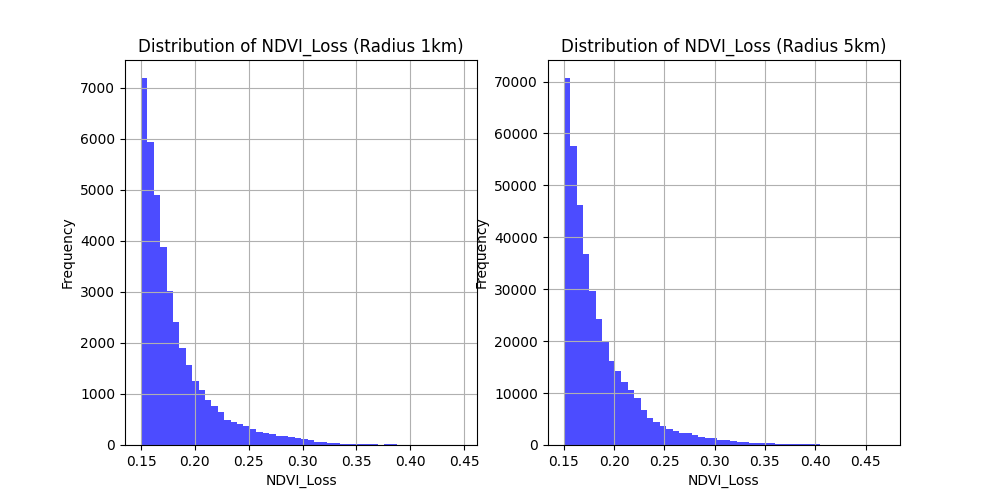

In [59]:
panda_df1 = data_1km.toPandas()
panda_df5 = data_5km.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distribution of the column 'ndvi-loss'
ax1.hist(panda_df1['NDVI_Loss'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of NDVI_Loss (Radius 1km)')
ax1.set_xlabel('NDVI_Loss')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'ndvi-loss'
ax2.hist(panda_df5['NDVI_Loss'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of NDVI_Loss (Radius 5km)')
ax2.set_xlabel('NDVI_Loss')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

### Interpretation:  
The two histogram represent the distribution of NDVI (Normalized Difference Vegetation Index) loss values in our sample data which NDVI loss larger than 0.15 using raidus 1km and 5 km as cutoff.  Both histograms are skewed to the right, indicating that most of the NDVI loss values are clustered at the lower end of the scale,  suggestting that the majority of the areas are experiencing moderate vegetation loss.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

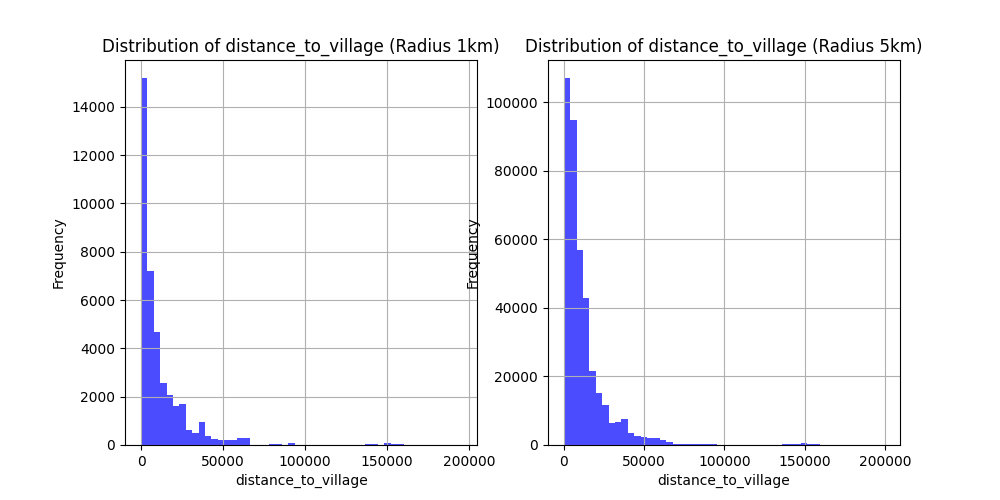

In [61]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_village'
ax1.hist(panda_df1['distance_to_village'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of distance_to_village (Radius 1km)')
ax1.set_xlabel('distance_to_village')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_village'
ax2.hist(panda_df5['distance_to_village'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of distance_to_village (Radius 5km)')
ax2.set_xlabel('distance_to_village')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

### Interpretation:  
The histogram represent the distribution of distances to the nearest villag values in our data which NDVI loss larger than 0.15. A large number of data points (highest frequency) are within 0-10,000 meters from a village, indicating that many of the areas sampled are close to villages. The distribution is spread out with distinct peaks, suggesting clusters of data points at specific distances from villages.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

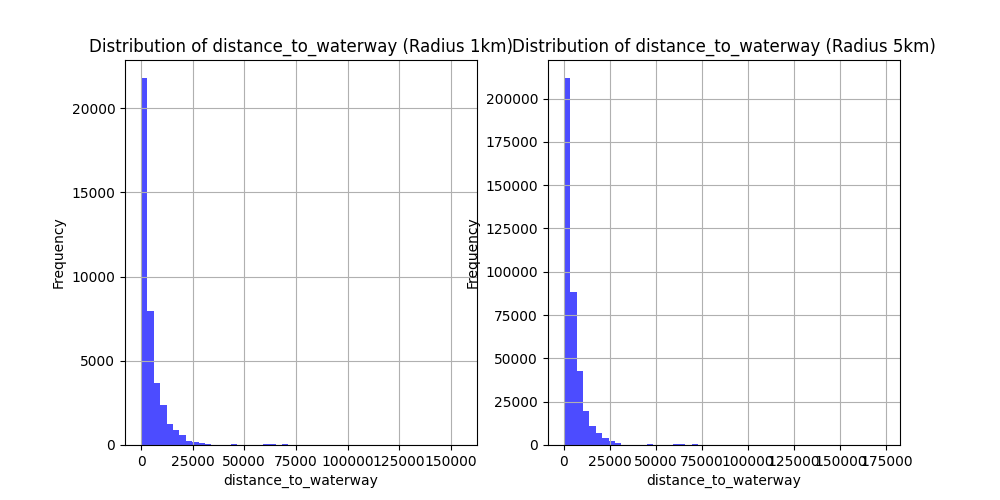

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_waterway'
ax1.hist(panda_df1['distance_to_waterway'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of distance_to_waterway (Radius 1km)')
ax1.set_xlabel('distance_to_waterway')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_waterway'
ax2.hist(panda_df5['distance_to_waterway'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of distance_to_waterway (Radius 5km)')
ax2.set_xlabel('distance_to_waterway')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

### Interpretation:  

Both distribution are highly skewed to the right, indicating that most data points have a small distance to the nearest waterway.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

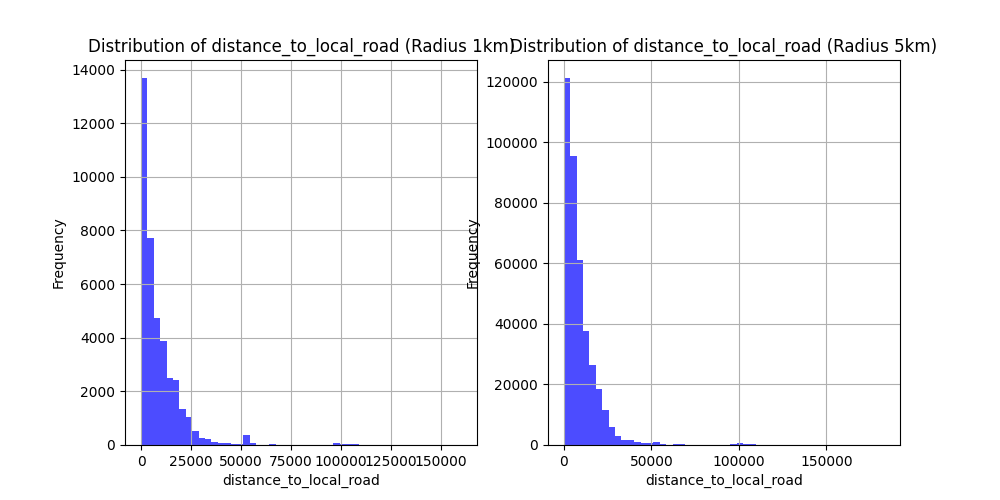

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_local_road'
ax1.hist(panda_df1['distance_to_local_road'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of distance_to_local_road (Radius 1km)')
ax1.set_xlabel('distance_to_local_road')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_local_road'
ax2.hist(panda_df5['distance_to_local_road'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of distance_to_local_road (Radius 5km)')
ax2.set_xlabel('distance_to_local_road')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

### Interpretation:  

Both distribution are highly skewed to the right, indicating that most data points have a small distance to local road.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

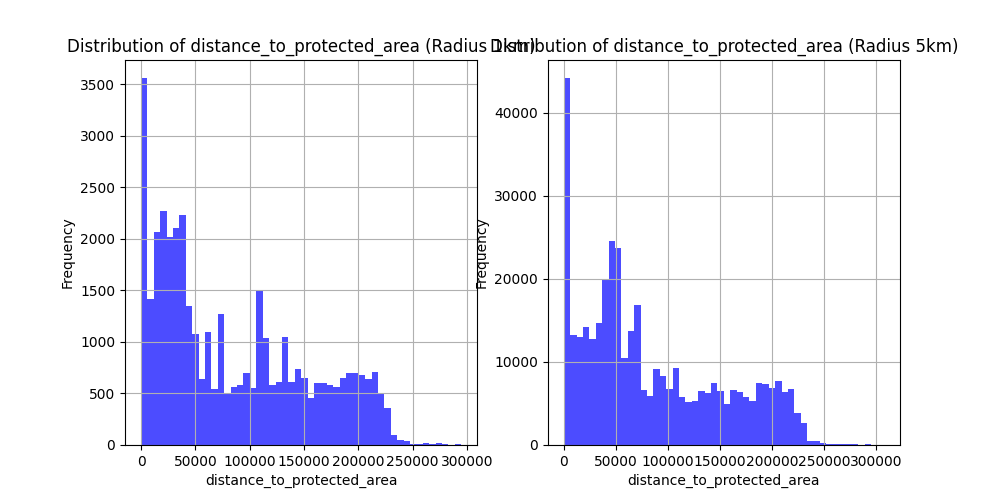

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting the distance_to_village of the column 'distance_to_protected_area'
ax1.hist(panda_df1['distance_to_protected_area'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribution of distance_to_protected_area (Radius 1km)')
ax1.set_xlabel('distance_to_protected_area')
ax1.set_ylabel('Frequency')
ax1.grid(True)


# Plotting the distribution of the column 'distance_to_protected_area'
ax2.hist(panda_df5['distance_to_protected_area'], bins=50, alpha=0.7, color='blue')
ax2.set_title('Distribution of distance_to_protected_area (Radius 5km)')
ax2.set_xlabel('distance_to_protected_area')
ax2.set_ylabel('Frequency')
ax2.grid(True)


%matplot plt

### Interpretation:  

Both plots suggest that the majority of locations with NDVI loss greater than 0.15 are situated closer to protected areas. There are clusters of locations at specific distances from protected areas, suggesting certain patterns or geographical features influencing these distributions.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

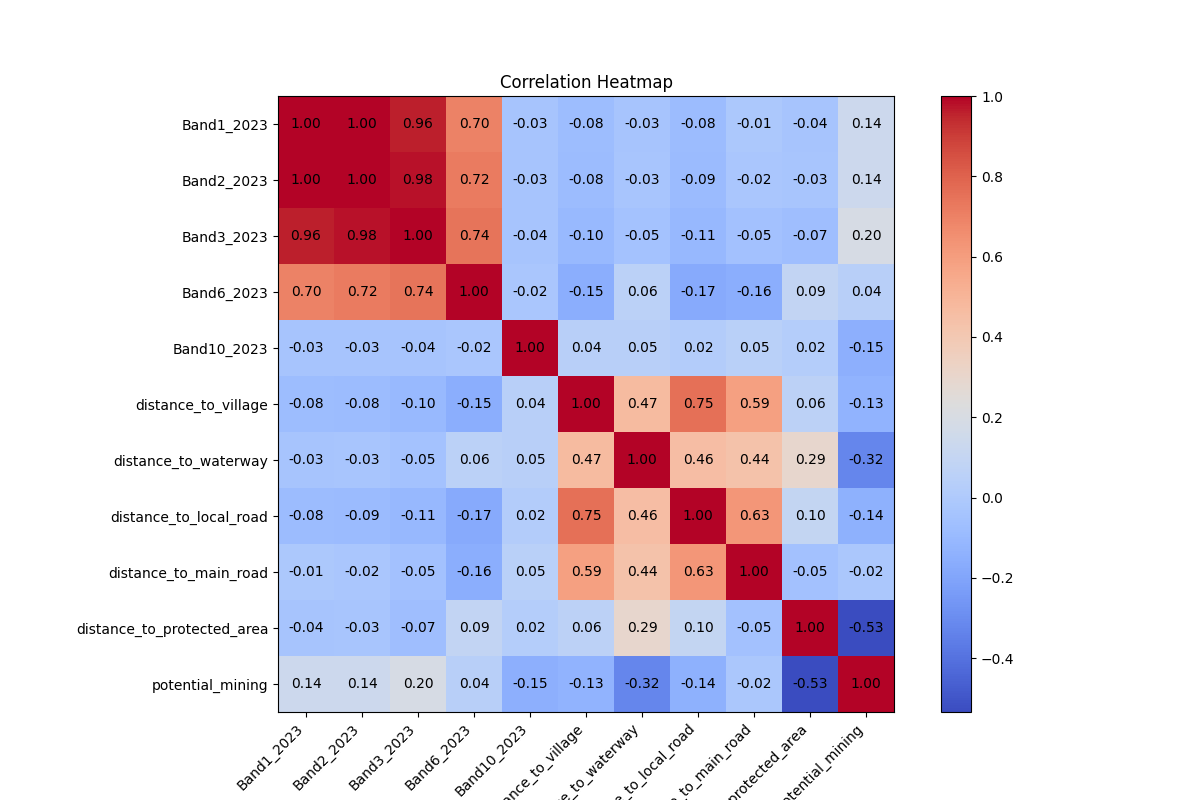

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

features = ['Band1_2023', 'Band2_2023', 'Band3_2023', 'Band6_2023', 'Band10_2023','distance_to_village', 'distance_to_waterway', 'distance_to_local_road', 'distance_to_main_road', 'distance_to_protected_area']

target = 'potential_mining'

# Select the required columns
selected_columns = features + [target]
data = combined_data_1km.select(selected_columns)

# Convert to Pandas DataFrame
pandas_df = data.toPandas()

# Compute the correlation matrix
correlation_matrix = pandas_df.corr()

# Plot the heatmap using Matplotlib
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(heatmap)

# Add labels
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

# Annotate the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title('Correlation Heatmap')


%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

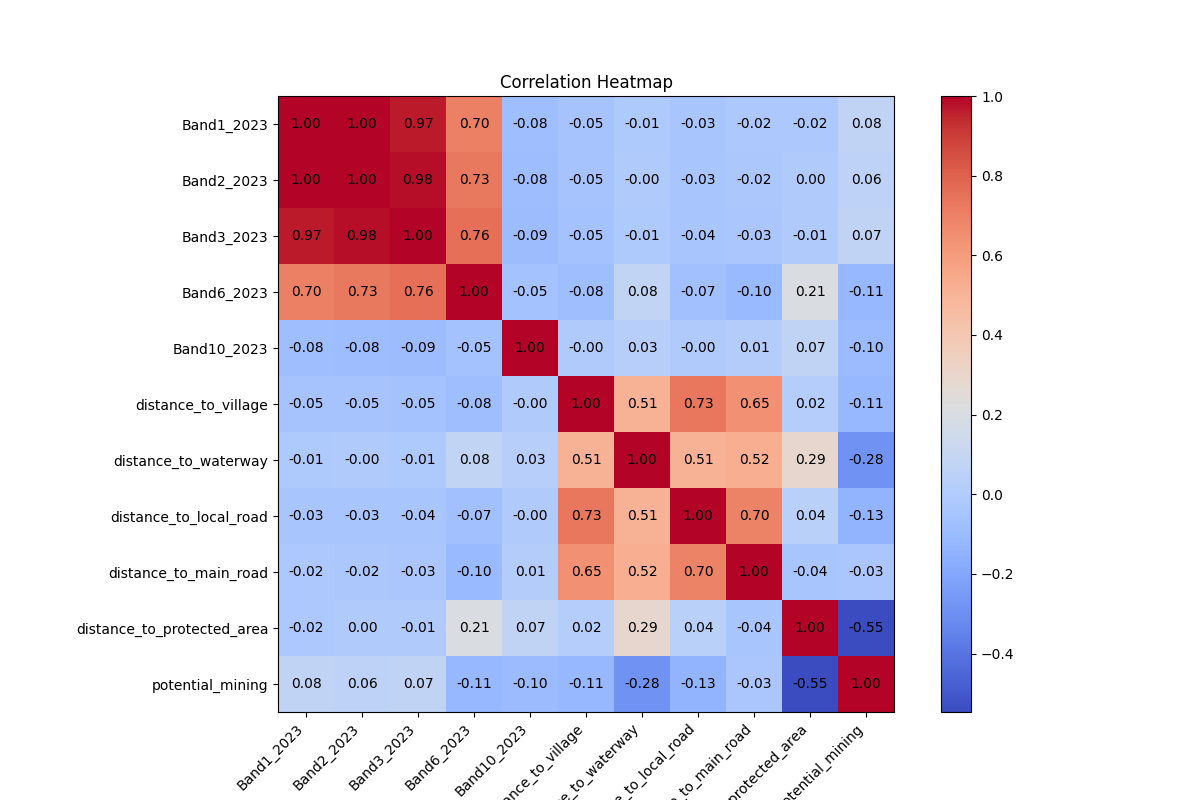

In [136]:
data = combined_data_5km.select(selected_columns)

# Convert to Pandas DataFrame
pandas_df = data.toPandas()

# Compute the correlation matrix
correlation_matrix = pandas_df.corr()

# Plot the heatmap using Matplotlib
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(heatmap)

# Add labels
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

# Annotate the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title('Correlation Heatmap')


%matplot plt

## Step 2:  Data Transformations and Feature Engineering

In [145]:
## Assembler feature
features = ['Band1_2023', 'Band2_2023', 'Band3_2023', 'Band6_2023', 'Band10_2023','distance_to_village', 'distance_to_waterway', 'distance_to_local_road', 'distance_to_main_road', 'distance_to_protected_area']
assembler = VectorAssembler(inputCols=features, outputCol='myfeatures')

# Add a normalizer
normalizer = Normalizer(inputCol="myfeatures", outputCol="normFeatures", p=1.0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Step 3: Develop Pipelines and Employee Machine Learnig Models to Predict

In [77]:
# split into train/test data
train_1, test_1 = data_1km.randomSplit([0.8, 0.2], seed=0)

# Persist data in memory to speed up I/O during training/testing
train_1.persist()
test_1.persist()

# confirm they're cached
print(train_1.is_cached, train_1.is_cached)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

True True

In [149]:
# split into train/test data
train_5, test_5 = data_5km.randomSplit([0.8, 0.2], seed=0)

# Persist data in memory to speed up I/O during training/testing
train_5.persist()
test_5.persist()

# confirm they're cached
print(train_5.is_cached, train_5.is_cached)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

True True

## 3.1 Logit Model

### 3.1.1  Develop Pipeline using Logit Model 

In [112]:
# Define the Logit Regression model
lr = LogisticRegression(featuresCol='normFeatures', labelCol='potential_mining')


# Create the pipeline
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            lr])
 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.1.2  Test Pipeline Performance using Data with Radius 1km as Classifier

In [114]:
# Train the model
logitmodel = pipeline.fit(train_1)

# Make predictions
predictions = logitmodel.transform(test_1)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="potential_mining", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))

# Compute additional metrics
prediction_and_labels = predictions.select(col("prediction").cast("double"), col("potential_mining").cast("double")).rdd.map(tuple)
metrics = MulticlassMetrics(prediction_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fn)))
print("True negative rate = {}".format(tn / (tn + fp)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.8171769787828739
Confusion Matrix:
 [[3348.  680.]
 [ 759. 3084.]]
True Positives (TP): 3084.0
True Negatives (TN): 3348.0
False Positives (FP): 680.0
False Negatives (FN): 759.0
True positive rate = 0.8024980483996877
True negative rate = 0.8311817279046674

In [ ]:
## Finding Optimal Model Parameters 

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, np.arange(0, 0.1, 0.01)) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

evaluator = RegressionEvaluator(labelCol="potential_mining", metricName="rmse")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

In [82]:
# Fit the model
cvModel = crossval.fit(train_1)

# Get the best model
bestModel = cvModel.bestModel
        

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
### Evaluate the Model on whole Data_1km

predictions = bestModel.transform(test_1)
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: ", rmse)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data:  0.42757808785896195

In [84]:
# Extract feature coefficients feature 

features_coefficients = bestModel.stages[-1].coefficients
importance = dict(zip(features, features_coefficients))
sorted_importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)

print("Feature Importances:")
for feature,coeff in sorted_importance:
    print(f"{feature}: {coeff}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Feature Importances:
Band2_2023: -1242.7270171805555
Band1_2023: 857.0485499857114
Band3_2023: 439.0449661340584
distance_to_waterway: -28.02976146345493
distance_to_local_road: -6.526415437195102
Band10_2023: -6.06285486214246
distance_to_protected_area: -3.222721180405095
Band6_2023: 3.0453984963723735
distance_to_main_road: 2.2264703502015912
distance_to_village: 0.7980967317211535

### 3.1.3  Test Pipeline Performance using Data with Radius 5km as Classifier

In [115]:
# Train the model
logitmodel_5 = pipeline.fit(train_5)

# Make predictions
predictions = logitmodel_5.transform(test_5)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="potential_mining", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))

# Compute additional metrics
prediction_and_labels = predictions.select(col("prediction").cast("double"), col("potential_mining").cast("double")).rdd.map(tuple)
metrics = MulticlassMetrics(prediction_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fn)))
print("True negative rate = {}".format(tn / (tn + fp)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.7739964311847697
Confusion Matrix:
 [[30073.  9902.]
 [ 7703. 30219.]]
True Positives (TP): 30219.0
True Negatives (TN): 30073.0
False Positives (FP): 9902.0
False Negatives (FN): 7703.0
True positive rate = 0.7968725278202626
True negative rate = 0.7522951844903064

In [91]:
# Fit the model
cvModel_5 = crossval.fit(train_5)

# Get the best model
bestModel_5 = cvModel_5.bestModel
        

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
### Evaluate the Model on whole Data_5km

predictions = bestModel.transform(test_5)
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: ", rmse)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data:  0.5385268503932056

In [95]:
# Extract feature coefficients feature 

features_coefficients = bestModel_5.stages[-1].coefficients
importance = dict(zip(features, features_coefficients))
sorted_importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)

print("Feature Importances:")
for feature,coeff in sorted_importance:
    print(f"{feature}: {coeff}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Feature Importances:
Band2_2023: -781.4905124785321
Band1_2023: 640.966725756835
Band3_2023: 209.08243743797908
distance_to_waterway: -19.358224135926207
Band6_2023: -10.904251598018174
distance_to_local_road: -7.803523555629307
distance_to_protected_area: -3.2034089166666924
Band10_2023: -2.0045006099355054
distance_to_main_road: 0.38497882575517794
distance_to_village: 0.053481010831184526

## 3.2 Random Forest 

### 3.2.1  Develop Pipeline 

In [147]:

# We can train a logistic regression classifier to predict the binary feature `potential_mining`.

rf = RandomForestClassifier(featuresCol='normFeatures', labelCol='potential_mining')

# Create the pipelisne
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            rf])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

###  3.2.2  Test Pipeline Performance using Data with Radius 1km as Classifier

In [98]:

## Evaluate random forest model usig data_1km
rf_model = pipeline.fit(train_1)

predictions = rf_model.transform(test_1)

evaluator = MulticlassClassificationEvaluator(labelCol="potential_mining", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: " + str(accuracy))


prediction_and_labels = predictions.select(col("prediction").cast("double"), col("potential_mining").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.8738406809808157
Confusion Matrix:
 [[3344.  684.]
 [ 309. 3534.]]
True Positives (TP): 3534.0
True Negatives (TN): 3344.0
False Positives (FP): 684.0
False Negatives (FN): 309.0
True positive rate = 0.8378378378378378
True negative rate = 0.9154119901450862

###  3.2.3  Test Pipeline Performance using Data with Radius 5km as Classifier

In [150]:
## Evaluate random forest model usig data_5km

rf_model_5 = pipeline.fit(train_5)

predictions_5 = rf_model_5.transform(test_5)

evaluator = MulticlassClassificationEvaluator(labelCol="potential_mining", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions_5)
print("Test Accuracy: " + str(accuracy))


prediction_and_labels = predictions_5.select(col("prediction").cast("double"), col("potential_mining").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.8339987419284439
Confusion Matrix:
 [[29012. 10963.]
 [ 1968. 35954.]]
True Positives (TP): 35954.0
True Negatives (TN): 29012.0
False Positives (FP): 10963.0
False Negatives (FN): 1968.0
True positive rate = 0.7663320331649509
True negative rate = 0.9364751452550032

## 3.3 Neutral Network

### 3.3.1 Develop Pipeline

In [100]:
# Specify layers for the neural network:
# Input layer of size 10 (features), two intermediate layers of size 16 and 32,
# and output layer of size 2 (classes)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [10, 16, 32, 2]

# Create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, labelCol="potential_mining", featuresCol="normFeatures")

# Create the pipeline
pipeline = Pipeline(stages=[assembler,
                            normalizer,
                            trainer])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.3.2  Test Pipeline Performance using Data with Radius 1km as Classifier

In [102]:
# Train the model using data_1km
model_1 = pipeline.fit(train_1)

# Compute accuracy on the test set
result = model_1.transform(test_1)
prediction_and_labels = result.select("prediction", "potential_mining")
evaluator = MulticlassClassificationEvaluator(labelCol="potential_mining", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test set accuracy = {accuracy}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test set accuracy = 0.8738406809808157

In [103]:
prediction_and_labels = result.select(col("prediction").cast("double"), col("potential_mining").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix:
 [[2965. 1063.]
 [ 546. 3297.]]
True Positives (TP): 3297.0
True Negatives (TN): 2965.0
False Positives (FP): 1063.0
False Negatives (FN): 546.0
True positive rate = 0.7561926605504588
True negative rate = 0.844488749643976

### 3.3.3  Test Pipeline Performance using Data with Radius 5km as Classifier

In [106]:
# Train the model using data_5km
model_5 = pipeline.fit(train_5)

# Compute accuracy on the test set
result = model_5.transform(test_5)
prediction_and_labels = result.select("prediction", "potential_mining")
evaluator = MulticlassClassificationEvaluator(labelCol="potential_mining", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test set accuracy = {accuracy}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test set accuracy = 0.8738406809808157

In [105]:
prediction_and_labels = result.select(col("prediction").cast("double"), col("potential_mining").cast("double")).rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_labels)


confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print("True positive rate = {}".format(tp / (tp + fp)))
print("True negative rate = {}".format(tn / (tn + fn)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix:
 [[28570. 11405.]
 [ 4130. 33792.]]
True Positives (TP): 33792.0
True Negatives (TN): 28570.0
False Positives (FP): 11405.0
False Negatives (FN): 4130.0
True positive rate = 0.747660242936478
True negative rate = 0.8737003058103976